In [1]:
#!pip install tensorflow

In [37]:
import numpy as np
import pandas as pd

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
import tensorflow.keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15,7
m.style.use('ggplot')
%matplotlib inline

In [3]:
dfRaw = pd.read_csv('dados/Electric_Production.csv').rename(columns = {'DATE':'Data','IPG2211A2N':'Producao'})
dfRaw['Data'] = pd.to_datetime(dfRaw['Data'])
dfRaw.set_index('Data', inplace=True)
dfRaw.head()

,Producao
Data,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
dfRaw.isna().sum()

Producao    0
dtype: int64

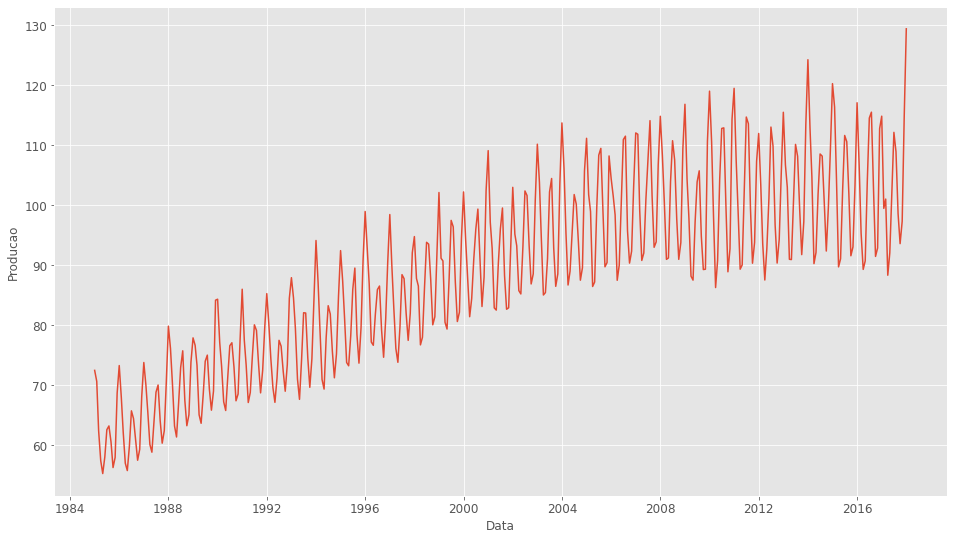

In [5]:
plt.figure(figsize=(16,9))
sns.lineplot(x = 'Data', y = 'Producao', data = dfRaw)
plt.show()

In [6]:
def split_train_test(serie,trainSize = 0.75):
    transition = int(len(serie)*trainSize)
    train = serie.iloc[:transition]
    test = serie.iloc[(transition):]
    
    return train, test

In [7]:
train, test = split_train_test(dfRaw)

In [9]:
test.head()

,Producao
Data,
2009-10-01,89.2977
2009-11-01,89.3585
2009-12-01,110.6844
2010-01-01,119.0166
2010-02-01,110.5330


In [12]:
treino, teste = np.array(train), np.array(test)

In [20]:
treino.shape

(297, 1)

In [21]:
test.shape

(100, 1)

In [22]:
trainset = treino.reshape(-1,1)
testset = teste.reshape(-1,1)

In [23]:
trainset.shape

(297, 1)

In [25]:
scaler = MinMaxScaler()
scaler.fit(trainset)

MinMaxScaler()

In [26]:
trainset = scaler.transform(trainset)
trainset.shape

(297, 1)

In [27]:
rep = 20

epochs = 200

n_input = 100

n_output = 100

n_features = 1

size_batch = 10

In [28]:
generator = TimeseriesGenerator(trainset, trainset, length=n_output, batch_size=size_batch)

In [31]:
X = dfRaw

In [32]:
resultado = np.zeros((n_input, rep))


for i in range(rep):
    
    modelo_lstm = Sequential()
    
    modelo_lstm.add(LSTM(40, activation='tanh', return_sequences=True, input_shape = (n_input, n_features)))
    
    modelo_lstm.add(LSTM(40, activation='relu'))
    
    # Adicionamos a primeira camada intermediária ou oculta
    modelo_lstm.add(Dense(50, activation = 'relu'))
    
    # Adicionamos a segunda camada intermediária ou oculta
    modelo_lstm.add(Dense(50, activation = 'relu'))
    
    # Adicionamos a camada de saída e tudo que precisamos é de 1 neurônio pois estamos prevendo apenas 1 valor.
    modelo_lstm.add(Dense(1))
    
    adam = optimizers.Adam(learning_rate=0.001)
    modelo_lstm.compile(optimizer=adam, loss = 'mean_squared_error')
    
    modelo_lstm.fit_generator(generator, epochs=epochs)
    
    pred_list = []
    
    batch = trainset[-n_input:].reshape((1,n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = X[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 3s 28ms/step - loss: 0.1722
Epoch 2/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0195
Epoch 3/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0177
Epoch 4/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0170
Epoch 5/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0175
Epoch 6/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0179
Epoch 7/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0173
Epoch 8/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0182
Epoch 9/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0171
Epoch 10/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0176
Epoch 11/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0169
Epoch 12/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0169
Epoch 13/200
20/20 [=================

20/20 [==============================] - 1s 29ms/step - loss: 0.0047
Epoch 102/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0048
Epoch 103/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0040
Epoch 104/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0044
Epoch 105/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0042
Epoch 106/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0038
Epoch 107/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0037
Epoch 108/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0035
Epoch 109/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0042
Epoch 110/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0037
Epoch 111/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0039
Epoch 112/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0039
Epoch 113/200
20/2

20/20 [==============================] - 1s 29ms/step - loss: 0.0015
Epoch 200/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0013
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 3s 30ms/step - loss: 0.1789
Epoch 2/200
20/20 [==============================] - 1s 30ms/step - loss: 0.0229
Epoch 3/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0186
Epoch 4/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0182
Epoch 5/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0176
Epoch 6/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0171
Epoch 7/200
20/20 [==============================] - 1s 30ms/step - loss: 0.0189
Epoch 8/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0170
Epoch 9/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0173
Epoch 10/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0166
Epoch 11/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0168
Epoch 12/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0166
Epoch 13/200
20/20 [=================

20/20 [==============================] - 1s 29ms/step - loss: 0.0039
Epoch 102/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0035
Epoch 103/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0039
Epoch 104/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0045
Epoch 105/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0037
Epoch 106/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0040
Epoch 107/200
20/20 [==============================] - 1s 30ms/step - loss: 0.0036
Epoch 108/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0031
Epoch 109/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0033
Epoch 110/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0036
Epoch 111/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0036
Epoch 112/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0032
Epoch 113/200
20/2

20/20 [==============================] - 1s 30ms/step - loss: 0.0015
Epoch 200/200
20/20 [==============================] - 1s 30ms/step - loss: 0.0013
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 29ms/step - loss: 0.2575
Epoch 2/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0221
Epoch 3/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0194
Epoch 4/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0184
Epoch 5/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0177
Epoch 6/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0201
Epoch 7/200
20/20 [==============================] - 1s 30ms/step - loss: 0.0195
Epoch 8/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0168
Epoch 9/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0177
Epoch 10/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0168
Epoch 11/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0174
Epoch 12/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0166
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 23ms/step - loss: 0.0042
Epoch 102/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0039
Epoch 103/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0035
Epoch 104/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 105/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0032
Epoch 106/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 107/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0032
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0033
Epoch 109/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 110/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0033
Epoch 111/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0029
Epoch 112/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0033
Epoch 113/200
20/2

20/20 [==============================] - 0s 23ms/step - loss: 270610144.0000
Epoch 200/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0047
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 24ms/step - loss: 0.1441
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0367
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0212
Epoch 4/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0176
Epoch 5/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0177
Epoch 6/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0177
Epoch 7/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0203
Epoch 8/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0203
Epoch 9/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0211
Epoch 10/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0169
Epoch 11/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0166
Epoch 12/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0166
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 23ms/step - loss: 0.0114
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0102
Epoch 103/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0105
Epoch 104/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0112
Epoch 105/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0097
Epoch 106/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0095
Epoch 107/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0081
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0085
Epoch 109/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0075
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0081
Epoch 111/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0071
Epoch 112/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0066
Epoch 113/200
20/2

20/20 [==============================] - 0s 25ms/step - loss: 0.0016
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0017
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 24ms/step - loss: 0.1872
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0238
Epoch 3/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0211
Epoch 4/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0181
Epoch 5/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0183
Epoch 6/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0174
Epoch 7/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0166
Epoch 8/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0180
Epoch 9/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0178
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0193
Epoch 11/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0168
Epoch 12/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0177
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 25ms/step - loss: 0.0040
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0034
Epoch 103/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 104/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0039
Epoch 105/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0111
Epoch 106/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0058
Epoch 107/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0051
Epoch 108/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0054
Epoch 109/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0046
Epoch 110/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0036
Epoch 111/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0031
Epoch 112/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0033
Epoch 113/200
20/2

20/20 [==============================] - 0s 24ms/step - loss: 0.0014
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0017
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 24ms/step - loss: 0.2525
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0285
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0189
Epoch 4/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0178
Epoch 5/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0174
Epoch 6/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0180
Epoch 7/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0177
Epoch 8/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0176
Epoch 9/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0184
Epoch 10/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0174
Epoch 11/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0178
Epoch 12/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0172
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 24ms/step - loss: 0.0093
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0081
Epoch 103/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0070
Epoch 104/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0068
Epoch 105/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0071
Epoch 106/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0062
Epoch 107/200
20/20 [==============================] - 1s 24ms/step - loss: 0.0052
Epoch 108/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0047
Epoch 109/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0047
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0051
Epoch 111/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0045
Epoch 112/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0047
Epoch 113/200
20/2

20/20 [==============================] - 0s 24ms/step - loss: 0.0014
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0013
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 24ms/step - loss: 0.1340
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0243
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0180
Epoch 4/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0171
Epoch 5/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0194
Epoch 6/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0180
Epoch 7/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0175
Epoch 8/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0198
Epoch 9/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0173
Epoch 10/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0167
Epoch 11/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0169
Epoch 12/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0172
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 24ms/step - loss: 0.0072
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0068
Epoch 103/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0066
Epoch 104/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0056
Epoch 105/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0061
Epoch 106/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0056
Epoch 107/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0056
Epoch 108/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0053
Epoch 109/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0051
Epoch 110/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0043
Epoch 111/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0051
Epoch 112/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0047
Epoch 113/200
20/2

20/20 [==============================] - 0s 24ms/step - loss: 0.0025
Epoch 200/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0026
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 25ms/step - loss: 0.2609
Epoch 2/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0383
Epoch 3/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0225
Epoch 4/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0182
Epoch 5/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0176
Epoch 6/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0178
Epoch 7/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0171
Epoch 8/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0183
Epoch 9/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0182
Epoch 10/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0167
Epoch 11/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0175
Epoch 12/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0171
Epoch 13/200
20/20 [=================

20/20 [==============================] - 1s 25ms/step - loss: 0.0045
Epoch 102/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0054
Epoch 103/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0050
Epoch 104/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0053
Epoch 105/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0044
Epoch 106/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0044
Epoch 107/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0061
Epoch 108/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0051
Epoch 109/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0041
Epoch 110/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 111/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0047
Epoch 112/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0053
Epoch 113/200
20/2

20/20 [==============================] - 1s 25ms/step - loss: 0.0018
Epoch 200/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0020
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 24ms/step - loss: 0.2485
Epoch 2/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0310
Epoch 3/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0197
Epoch 4/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0177
Epoch 5/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0191
Epoch 6/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0178
Epoch 7/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0172
Epoch 8/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0164
Epoch 9/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0162
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0168
Epoch 11/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0180
Epoch 12/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0183
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 23ms/step - loss: 0.0057
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0052
Epoch 103/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0051
Epoch 104/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0047
Epoch 105/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0041
Epoch 106/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0044
Epoch 107/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0036
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0043
Epoch 109/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0038
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0037
Epoch 111/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0052
Epoch 112/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0043
Epoch 113/200
20/2

20/20 [==============================] - 0s 25ms/step - loss: 0.0017
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0017
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 24ms/step - loss: 0.1304
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0244
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0190
Epoch 4/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0178
Epoch 5/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0175
Epoch 6/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0173
Epoch 7/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0180
Epoch 8/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0184
Epoch 9/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0201
Epoch 10/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0184
Epoch 11/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0172
Epoch 12/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0172
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 24ms/step - loss: 0.0039
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0039
Epoch 103/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0038
Epoch 104/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0037
Epoch 105/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0039
Epoch 106/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0039
Epoch 107/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0043
Epoch 108/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0047
Epoch 109/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0039
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0040
Epoch 111/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0038
Epoch 112/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0042
Epoch 113/200
20/2

20/20 [==============================] - 0s 24ms/step - loss: 0.0015
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0016
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 24ms/step - loss: 0.3151
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0524
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0189
Epoch 4/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0180
Epoch 5/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0170
Epoch 6/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0175
Epoch 7/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0167
Epoch 8/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0183
Epoch 9/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0171
Epoch 10/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0209
Epoch 11/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0190
Epoch 12/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0172
Epoch 13/200
20/20 [=================

20/20 [==============================] - 1s 25ms/step - loss: 0.0043
Epoch 102/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0041
Epoch 103/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0038
Epoch 104/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0044
Epoch 105/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0042
Epoch 106/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0046
Epoch 107/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0052
Epoch 108/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0045
Epoch 109/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0037
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0044
Epoch 111/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0044
Epoch 112/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0040
Epoch 113/200
20/2

20/20 [==============================] - 0s 24ms/step - loss: 0.0018
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0023
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 24ms/step - loss: 0.1973
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0191
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0179
Epoch 4/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0185
Epoch 5/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0198
Epoch 6/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0170
Epoch 7/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0181
Epoch 8/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0177
Epoch 9/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0200
Epoch 10/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0171
Epoch 11/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0171
Epoch 12/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0182
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 24ms/step - loss: 0.0039
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0038
Epoch 103/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0045
Epoch 104/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0042
Epoch 105/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0043
Epoch 106/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0067
Epoch 107/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0042
Epoch 108/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0041
Epoch 109/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0040
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0041
Epoch 111/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0042
Epoch 112/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0040
Epoch 113/200
20/2

20/20 [==============================] - 0s 24ms/step - loss: 0.0016
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0015
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 23ms/step - loss: 0.2956
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0415
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0227
Epoch 4/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0182
Epoch 5/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0178
Epoch 6/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0176
Epoch 7/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0176
Epoch 8/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0168
Epoch 9/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0177
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0170
Epoch 11/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0167
Epoch 12/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0198
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 24ms/step - loss: 0.0052
Epoch 102/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0057
Epoch 103/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0054
Epoch 104/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0052
Epoch 105/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0046
Epoch 106/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0052
Epoch 107/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0046
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0052
Epoch 109/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0040
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0044
Epoch 111/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0041
Epoch 112/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0047
Epoch 113/200
20/2

20/20 [==============================] - 0s 23ms/step - loss: 0.0023
Epoch 200/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0020
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 23ms/step - loss: 0.1630
Epoch 2/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0263
Epoch 3/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0187
Epoch 4/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0171
Epoch 5/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0167
Epoch 6/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0169
Epoch 7/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0169
Epoch 8/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0167
Epoch 9/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0170
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0178
Epoch 11/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0166
Epoch 12/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0168
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 23ms/step - loss: 0.0057
Epoch 102/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0059
Epoch 103/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0040
Epoch 104/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0042
Epoch 105/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0047
Epoch 106/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0045
Epoch 107/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0036
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 109/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0035
Epoch 110/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 111/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 112/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0033
Epoch 113/200
20/2

20/20 [==============================] - 0s 23ms/step - loss: 0.0017
Epoch 200/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0018
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 23ms/step - loss: 0.1131
Epoch 2/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0191
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0189
Epoch 4/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0175
Epoch 5/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0173
Epoch 6/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0171
Epoch 7/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0171
Epoch 8/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0168
Epoch 9/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0170
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0174
Epoch 11/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0168
Epoch 12/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0176
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 23ms/step - loss: 0.0036
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0045
Epoch 103/200
20/20 [==============================] - 1s 28ms/step - loss: 0.0042
Epoch 104/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0036
Epoch 105/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0044
Epoch 106/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0042
Epoch 107/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0032
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0047
Epoch 109/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0041
Epoch 110/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0038
Epoch 111/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0038
Epoch 112/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0041
Epoch 113/200
20/2

20/20 [==============================] - 0s 24ms/step - loss: 0.0021
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0019
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 23ms/step - loss: 0.1857
Epoch 2/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0239
Epoch 3/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0218
Epoch 4/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0191
Epoch 5/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0186
Epoch 6/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0181
Epoch 7/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0172
Epoch 8/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0173
Epoch 9/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0175
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0173
Epoch 11/200
20/20 [==============================] - 0s 22ms/step - loss: 0.0187
Epoch 12/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0167
Epoch 13/200
20/20 [=================

20/20 [==============================] - 1s 27ms/step - loss: 0.0057
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0067
Epoch 103/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0058
Epoch 104/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0041
Epoch 105/200
20/20 [==============================] - 1s 34ms/step - loss: 0.0046
Epoch 106/200
20/20 [==============================] - 1s 29ms/step - loss: 0.0050
Epoch 107/200
20/20 [==============================] - 1s 27ms/step - loss: 0.0045
Epoch 108/200
20/20 [==============================] - 1s 27ms/step - loss: 0.0040
Epoch 109/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0040
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0033
Epoch 111/200
20/20 [==============================] - 1s 27ms/step - loss: 0.0039
Epoch 112/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0040
Epoch 113/200
20/2

20/20 [==============================] - 0s 24ms/step - loss: 0.0011
Epoch 200/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0012
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 23ms/step - loss: 0.1716
Epoch 2/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0199
Epoch 3/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0177
Epoch 4/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0172
Epoch 5/200
20/20 [==============================] - 0s 25ms/step - loss: 0.0171
Epoch 6/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0173
Epoch 7/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0163
Epoch 8/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0179
Epoch 9/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0168
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0163
Epoch 11/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0166
Epoch 12/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0196
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 24ms/step - loss: 0.0056
Epoch 102/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0041
Epoch 103/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0049
Epoch 104/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0039
Epoch 105/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0035
Epoch 106/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0040
Epoch 107/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0043
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0047
Epoch 109/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0037
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0031
Epoch 111/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0030
Epoch 112/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 113/200
20/2

20/20 [==============================] - 0s 23ms/step - loss: 0.0016
Epoch 200/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0022
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 23ms/step - loss: 0.1084
Epoch 2/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0277
Epoch 3/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0187
Epoch 4/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0194
Epoch 5/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0177
Epoch 6/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0173
Epoch 7/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0176
Epoch 8/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0165
Epoch 9/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0167
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0173
Epoch 11/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0179
Epoch 12/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0178
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 23ms/step - loss: 0.0035
Epoch 102/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0034
Epoch 103/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0032
Epoch 104/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0031
Epoch 105/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0027
Epoch 106/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0032
Epoch 107/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0026
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0025
Epoch 109/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0026
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0029
Epoch 111/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0050
Epoch 112/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0034
Epoch 113/200
20/2

20/20 [==============================] - 0s 23ms/step - loss: 0.0017
Epoch 200/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0019
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 23ms/step - loss: 0.1670
Epoch 2/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0300
Epoch 3/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0201
Epoch 4/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0181
Epoch 5/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0172
Epoch 6/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0175
Epoch 7/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0171
Epoch 8/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0170
Epoch 9/200
20/20 [==============================] - 1s 27ms/step - loss: 0.0168
Epoch 10/200
20/20 [==============================] - 1s 25ms/step - loss: 0.0171
Epoch 11/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0176
Epoch 12/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0169
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 24ms/step - loss: 0.0068
Epoch 102/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0069
Epoch 103/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0061
Epoch 104/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0060
Epoch 105/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0058
Epoch 106/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0048
Epoch 107/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0050
Epoch 108/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0049
Epoch 109/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0053
Epoch 110/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0048
Epoch 111/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0045
Epoch 112/200
20/20 [==============================] - 0s 24ms/step - loss: 0.0037
Epoch 113/200
20/2

20/20 [==============================] - 0s 23ms/step - loss: 0.0024
Epoch 200/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0016
Epoch 1/200


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_63664\3245631302.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  modelo_lstm.fit_generator(generator, epochs=epochs)


20/20 [==============================] - 2s 23ms/step - loss: 0.1111
Epoch 2/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0235
Epoch 3/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0184
Epoch 4/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0176
Epoch 5/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0171
Epoch 6/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0171
Epoch 7/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0170
Epoch 8/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0166
Epoch 9/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0174
Epoch 10/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0173
Epoch 11/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0180
Epoch 12/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0170
Epoch 13/200
20/20 [=================

20/20 [==============================] - 0s 23ms/step - loss: 0.0049
Epoch 102/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0039
Epoch 103/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0048
Epoch 104/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0042
Epoch 105/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0046
Epoch 106/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0043
Epoch 107/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0041
Epoch 108/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0050
Epoch 109/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0042
Epoch 110/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0047
Epoch 111/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0043
Epoch 112/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0041
Epoch 113/200
20/2

20/20 [==============================] - 0s 23ms/step - loss: 0.0024
Epoch 200/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0028
[[ 91.43382227  88.65585107  86.75796479 ...  87.8531292   87.83957352
   89.1059127 ]
 [ 92.89771059  92.77987851  86.30322449 ...  90.14241407  91.41266192
   92.11591806]
 [107.09360146 107.23863289  96.94148197 ... 101.83894193 106.18955485
  106.52505507]
 ...
 [ 95.09340006  91.82309053  85.63616571 ...  83.96393175  88.03118998
   89.07551235]
 [109.46248972 106.38540631  80.88266468 ...  93.78406185 101.12778412
  102.83904793]
 [116.38249903 111.29781895  86.74662379 ...  99.62823377 108.44275236
  107.45762837]]


In [33]:
resultado_final = np.zeros((resultado.shape[0],1))
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])
resultado_final

array([[ 88.95413075],
       [ 91.54269594],
       [105.56736235],
       [110.96013064],
       [104.19053927],
       [ 96.32926171],
       [ 87.87289997],
       [ 88.38494041],
       [ 97.32840521],
       [104.84046664],
       [104.83583252],
       [ 95.4482108 ],
       [ 88.6284869 ],
       [ 90.94923573],
       [104.69108819],
       [110.27139488],
       [103.67897366],
       [ 95.98307076],
       [ 87.58578832],
       [ 87.91526219],
       [ 96.7574645 ],
       [104.21285994],
       [104.25089925],
       [ 95.08827149],
       [ 88.38880875],
       [ 90.65981711],
       [104.11003645],
       [109.67037922],
       [103.22951409],
       [ 95.63629993],
       [ 87.42920981],
       [ 87.64286635],
       [ 96.30818899],
       [103.76593257],
       [103.72032434],
       [ 94.73864487],
       [ 88.30830492],
       [ 90.68266082],
       [103.77888572],
       [109.10542049],
       [102.81650635],
       [ 95.28756724],
       [ 87.29939992],
       [ 87

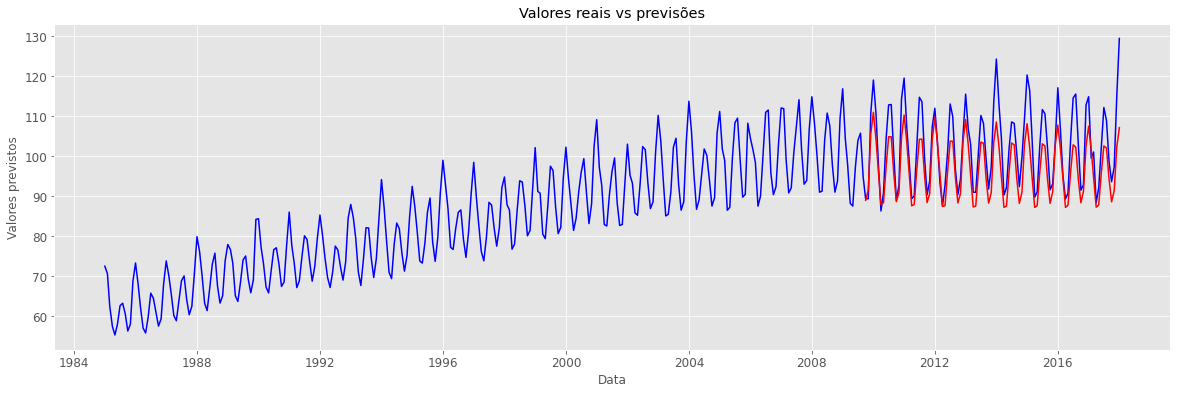

In [36]:
plt.figure(figsize=(20,6))

plt.plot(dfRaw.index,
        dfRaw.values,
        label = 'Valores observados',
        color = "blue")

plt.plot(dfRaw[297:].index,
        resultado_final,
        color = 'red',
        label = 'Previsões realizadas com o modelo')
plt.title('Valores reais vs previsões')
plt.xlabel("Data")
plt.ylabel("Valores previstos")
plt.show()

In [39]:
rmse = np.sqrt(mean_squared_error(test.values, resultado_final))
print(rmse)

6.813046801600656
